# Robot Class

In this project, we'll be localizing a robot in a 2D grid world. The basis for simultaneous localization and mapping (SLAM) is to gather information from a robot's sensors and motions over time, and then use information about measurements and motion to re-construct a map of the world.

### Uncertainty

As you've learned, robot motion and sensors have some uncertainty associated with them. For example, imagine a car driving up hill and down hill; the speedometer reading will likely overestimate the speed of the car going up hill and underestimate the speed of the car going down hill because it cannot perfectly account for gravity. Similarly, we cannot perfectly predict the *motion* of a robot. A robot is likely to slightly overshoot or undershoot a target location.

In this notebook, we'll look at the `robot` class that is *partially* given to you for the upcoming SLAM notebook. First, we'll create a robot and move it around a 2D grid world. Then, **you'll be tasked with defining a `sense` function for this robot that allows it to sense landmarks in a given world**! It's important that you understand how this robot moves, senses, and how it keeps track of different landmarks that it sees in a 2D grid world, so that you can work with it's movement and sensor data.

---

Before we start analyzing robot motion, let's load in our resources and define the `robot` class. You can see that this class initializes the robot's position and adds measures of uncertainty for motion. You'll also see a `sense()` function which is not yet implemented, and you will learn more about that later in this notebook.

In [1]:
# import some resources
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [9]:
### ------------------------------------- ###
# Below, is the robot class
#
# This robot lives in 2D, x-y space, and its motion is
# pointed in a random direction, initially.
# It moves in a straight line until it comes close to a wall
# at which point it stops.
#
# For measurements, it  senses the x- and y-distance
# to landmarks. This is different from range and bearing as
# commonly studied in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math.
#

import random

from collections import namedtuple
from dataclasses import dataclass
from typing import Protocol
import numpy as np

Landmark: tuple[float, float, int] = namedtuple(
    "Landmark",
    ["x", "y", "index"],
)


class MeasurementStrategy(Protocol):
    """Strategy for sensing"""

    def __call__(
        self,
        robot_pos: tuple[float, float],
        landmark: Landmark,
    ) -> float:
        ...


def euclidean_dist_strategy(
    robot_pos: tuple[float, float],
    landmark: Landmark,
) -> float:
    """
    Measure the euclidean distance from a landmark and the robot without
    noise.

    Parameters
    ----------
    robot_pos : tuple[float, float]
        robot position in (x, y) format
    landmark : Landmark | tuple[float, float, int]
        landmark item - generated by robot class
    """
    land_x, land_y, *_ = landmark
    p_robot = np.array(robot_pos)
    p_land = np.array([land_x, land_y])
    return np.sqrt(((p_robot - p_land) ** 2).sum())


def square_dist_strategy(
    robot_pos: tuple[float, float],
    landmark: Landmark,
) -> float:
    """
    Measure the euclidean distance from a landmark and the robot without
    noise.

    Parameters
    ----------
    robot_pos : tuple[float, float]
        robot position in (x, y) format
    landmark : Landmark | tuple[float, float, int]
        landmark item - generated by robot class
    """
    land_x, land_y, *_ = landmark
    p_robot = np.array(robot_pos)
    p_land = np.array([land_x, land_y])
    return (p_robot - p_land).max()


# the robot class
@dataclass
class robot:
    """
    creates a robot with the specified parameters and initializes
    the location (self.x, self.y) to the center of the world

    Parameters
    ----------
    world_size : float
        size of square world for robot to explore
    measurement_range : float
        range of sensor using measurement_strategy
    motion_noise : float
        amount of noise in motion
    measurement_noise : float
        amount of noise in measurement
    measurement_strategy : MeasurementStrategy
        strategy to measure distance
    """

    world_size: float = 100.0
    measurement_range: float = 30.0
    motion_noise: float = 1.0
    measurement_noise: float = 1.0
    measurement_strategy: MeasurementStrategy = square_dist_strategy

    def __post_init__(self):
        self.x = self.world_size / 2.0
        self.y = self.world_size / 2.0
        self.landmarks = []
        self.num_landmarks = 0

    # returns a positive, random float
    # [ACM] Incorrect - this returns a random float from [-1, 1]
    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True

    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    ## TODO: complete the sense function
    def sense(self):
        """This function does not take in any parameters, instead it references internal variables
        (such as self.landmarks) to measure the distance between the robot and any landmarks
        that the robot can see (that are within its measurement range).
        This function returns a list of landmark indices, and the measured distances (dx, dy)
        between the robot's position and said landmarks.
        This function should account for measurement_noise and measurement_range.
        One item in the returned list should be in the form: [landmark_index, dx, dy].
        """

        measurements = []

        ## TODO: iterate through all of the landmarks in a world

        ## TODO: For each landmark
        ## 1. compute dx and dy, the distances between the robot and the landmark
        ## 2. account for measurement noise by *adding* a noise component to dx and dy
        ##    - The noise component should be a random value between [-1.0, 1.0)*measurement_noise
        ##    - Feel free to use the function self.rand() to help calculate this noise component
        ##    - It may help to reference the `move` function for noise calculation
        ## 3. If either of the distances, dx or dy, fall outside of the internal var, measurement_range
        ##    then we cannot record them; if they do fall in the range, then add them to the measurements list
        ##    as list.append([index, dx, dy]), this format is important for data creation done later
        # [ACM] Engineering Decision - I used the euclidean distance to measure
        #       my landmarks - this may be generate a flaw in the results
        #       compared to other submissions. Consider changing this to a more
        #       rudimentary calculation if problems arise.
        for landmark in self.landmarks:
            # landmark_idx = landmark.index
            dist = self.measurement_strategy((self.x, self.y), landmark)
            measured_r = dist + self.rand() * self.measurement_noise
            if measured_r > self.measurement_range:
                continue
            measurements.append(landmark)

        ## TODO: return the final, complete list of measurements
        return measurements

    # --------
    # make_landmarks:
    # make random landmarks located in the world
    #
    # [ACM] Engineering decision - added named tuple - Landmark and index to
    #       landmarks - this will ease flow of other values as these landmarks
    #       will be passed around.
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            x = round(random.random() * self.world_size)
            y = round(random.random() * self.world_size)
            landmark = Landmark(x, y, i)
            self.landmarks.append(landmark)
        self.num_landmarks = num_landmarks

    # called when print(robot) is called; prints the robot's location
    def __repr__(self):
        return "Robot: [x=%.5f y=%.5f]" % (self.x, self.y)


####### END robot class #######



## Define a world and a robot

Next, let's instantiate a robot object. As you can see in `__init__` above, the robot class takes in a number of parameters including a world size and some values that indicate the sensing and movement capabilities of the robot.

In the next example, we define a small 10x10 square world, a measurement range that is half that of the world and small values for motion and measurement noise. These values will typically be about 10 times larger, but we ust want to demonstrate this behavior on a small scale. You are also free to change these values and note what happens as your robot moves!

In [10]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)

Robot: [x=5.00000 y=5.00000]


## Visualizing the World

In the given example, we can see/print out that the robot is in the middle of the 10x10 world at (x, y) = (5.0, 5.0), which is exactly what we expect!

However, it's kind of hard to imagine this robot in the center of a world, without visualizing the grid itself, and so in the next cell we provide a helper visualization function, `display_world`, that will display a grid world in a plot and draw a red `o` at the location of our robot, `r`. The details of how this function wors can be found in the `helpers.py` file in the home directory; you do not have to change anything in this `helpers.py` file.

Robot: [x=5.00000 y=5.00000]


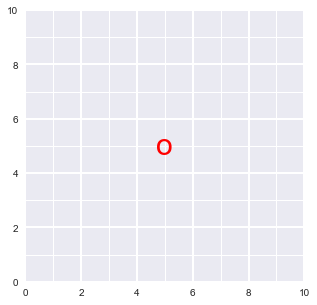

In [11]:
# import helper function
from helpers import display_world

# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])

## Movement

Now you can really picture where the robot is in the world! Next, let's call the robot's `move` function. We'll ask it to move some distance `(dx, dy)` and we'll see that this motion is not perfect by the placement of our robot `o` and by the printed out position of `r`. 

Try changing the values of `dx` and `dy` and/or running this cell multiple times; see how the robot moves and how the uncertainty in robot motion accumulates over multiple movements.

#### For a `dx` = 1, does the robot move *exactly* one spot to the right? What about `dx` = -1? What happens if you try to move the robot past the boundaries of the world?

[ACM] The robot has error within it's movement and does not move exactly it's
input distance. Moreover, if the robot attempts to move more than the world the
robot will not move. 

Robot: [x=5.92144 y=7.10508]


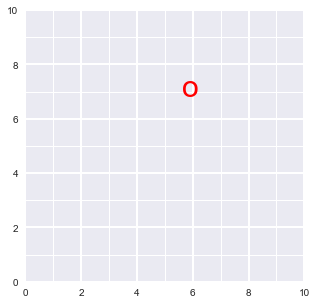

In [12]:
# choose values of dx and dy (negative works, too)
dx = 1
dy = 2
r.move(dx, dy)

# print out the exact location
print(r)

# display the world after movement, not that this is the same call as before
# the robot tracks its own movement
display_world(int(world_size), [r.x, r.y])

## Landmarks

Next, let's create landmarks, which are measurable features in the map. You can think of landmarks as things like notable buildings, or something smaller such as a tree, rock, or other feature.

The robot class has a function `make_landmarks` which randomly generates locations for the number of specified landmarks. Try changing `num_landmarks` or running this cell multiple times to see where these landmarks appear. We have to pass these locations as a third argument to the `display_world` function and the list of landmark locations is accessed similar to how we find the robot position `r.landmarks`. 

Each landmark is displayed as a purple `x` in the grid world, and we also print out the exact `[x, y]` locations of these landmarks at the end of this cell.

Robot: [x=5.92144 y=7.10508]


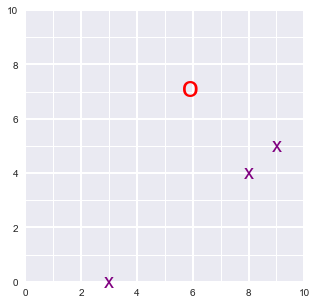

Landmark locations [x,y]:  [Landmark(x=3, y=0, index=0), Landmark(x=8, y=4, index=1), Landmark(x=9, y=5, index=2)]


In [15]:
# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

## Sense

Once we have some landmarks to sense, we need to be able to tell our robot to *try* to sense how far they are away from it. It will be up t you to code the `sense` function in our robot class.

The `sense` function uses only internal class parameters and returns a list of the the measured/sensed x and y distances to the landmarks it senses within the specified `measurement_range`. 

### TODO: Implement the `sense` function 

Follow the `##TODO's` in the class code above to complete the `sense` function for the robot class. Once you have tested out your code, please **copy your complete `sense` code to the `robot_class.py` file in the home directory**. By placing this complete code in the `robot_class` Python file, we will be able to refernce this class in a later notebook.

The measurements have the format, `[i, dx, dy]` where `i` is the landmark index (0, 1, 2, ...) and `dx` and `dy` are the measured distance between the robot's location (x, y) and the landmark's location (x, y). This distance will not be perfect since our sense function has some associated `measurement noise`.

---

In the example in the following cell, we have a given our robot a range of `5.0` so any landmarks that are within that range of our robot's location, should appear in a list of measurements. Not all landmarks are guaranteed to be in our visibility range, so this list will be variable in length.

*Note: the robot's location is often called the **pose** or `[Pxi, Pyi]` and the landmark locations are often written as `[Lxi, Lyi]`. You'll see this notation in the next notebook.*

In [16]:
# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

[Landmark(x=8, y=4, index=1), Landmark(x=9, y=5, index=2)]


**Refer back to the grid map above. Do these measurements make sense to you? Are all the landmarks captured in this list (why/why not)?**

---
## Data

#### Putting it all together

To perform SLAM, we'll collect a series of robot sensor measurements and motions, in that order, over a defined period of time. Then we'll use only this data to re-construct the map of the world with the robot and landmar locations. You can think of SLAM as peforming what we've done in this notebook, only backwards. Instead of defining a world and robot and creating movement and sensor data, it will be up to you to use movement and sensor measurements to reconstruct the world!

In the next notebook, you'll see this list of movements and measurements (which you'll use to re-construct the world) listed in a structure called `data`. This is an array that holds sensor measurements and movements in a specific order, which will be useful to call upon when you have to extract this data and form constraint matrices and vectors.

`data` is constructed over a series of time steps as follows:

In [17]:
data = []

# after a robot first senses, then moves (one time step)
# that data is appended like so:
data.append([measurements, [dx, dy]])

# for our example movement and measurement
print(data)

[[[Landmark(x=8, y=4, index=1), Landmark(x=9, y=5, index=2)], [1, 2]]]


In [18]:
# in this example, we have only created one time step (0)
time_step = 0

# so you can access robot measurements:
print('Measurements: ', data[time_step][0])

# and its motion for a given time step:
print('Motion: ', data[time_step][1])

Measurements:  [Landmark(x=8, y=4, index=1), Landmark(x=9, y=5, index=2)]
Motion:  [1, 2]


### Final robot class

Before moving on to the last notebook in this series, please make sure that you have copied your final, completed `sense` function into the `robot_class.py` file in the home directory. We will be using this file in the final implementation of slam!